<a href="https://colab.research.google.com/github/sateesh12/tf/blob/main/vgg16_transfer_learning_with_fine_tuning_asl.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import random
import numpy as np
import os
import matplotlib.pyplot as plt
import cv2
import zipfile
import requests
import glob as glob

from tensorflow.keras.utils import image_dataset_from_directory
from matplotlib.ticker import (MultipleLocator, FormatStrFormatter)
from dataclasses import dataclass

block_plot = False
plt.rcParams['figure.figsize'] = (12,9)
SEED_VALUE = 42

In [ ]:
def download_and_unzip(url, save_name):
    #url = url
    file = requests.get(url)
    open(save_name, 'wb').write(file.content)
    try:
        with zipfile.ZipFile(save_name) as z:
            z.extractall("./")
            print('Extracted all')
    except:
        print('Invalid data')

download_and_unzip('https://www.dropbox.com/s/7huaqeavdbz32la/dataset_ASL_150.zip?dl=1',
    'dataset_ASL_150.zip')

Extracted all


In [ ]:
from keras.api._v2.keras import datasets
@dataclass (frozen=True)
class DatasetConfig:
    NUM_CLASSES:  int = 29
    IMG_HEIGHT:    int = 224
    IMG_WIDTH:     int  = 224
    CHANNELS:        int  = 3
    BATCH_SIZE:     int  = 32
    DATA_ROOT: str='./dataset_ASL_150'

@dataclass(frozen=True)
class TrainingConfig:
    BATCH_SIZE: int = 32
    EPOCSHS:     int = 51
    LEARNING_RATE: float = 0.0001
    CHECKPOINT_DIR: str = './saved_models_asl'


In [ ]:
# Load an existing VGG16  model using Keras.
input_shape = (DatasetConfig.IMG_HEIGHT, DatasetConfig.IMG_WIDTH, DatasetConfig.CHANNELS)
print('Load the model with random weights')
vgg16_conv_base = tf.keras.applications.vgg16.VGG16(input_shape=input_shape, include_top=False, weights=None)
vgg16_conv_base.trainable = True
print('All kernel weights are trainable')
print(vgg16_conv_base.summary())

Load the model with random weights
All kernel weights are trainable
Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                           

In [ ]:
# Add classifictaion layer, the above CNN extracted the features.
inputs = tf.keras.Input(shape=input_shape)

x = tf.keras.applications.vgg16.preprocess_input(inputs)
x = vgg16_conv_base(x)
x = layers.Flatten()(x)
x = layers.Dense(256, activation='relu')(x)
outputs = layers.Dense(DatasetConfig.NUM_CLASSES, activation='softmax')(x)
vgg16_model = keras.Model(inputs, outputs)
print(vgg16_model.summary())

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 tf.__operators__.getitem (S  (None, 224, 224, 3)      0         
 licingOpLambda)                                                 
                                                                 
 tf.nn.bias_add (TFOpLambda)  (None, 224, 224, 3)      0         
                                                                 
 vgg16 (Functional)          (None, 7, 7, 512)         14714688  
                                                                 
 flatten (Flatten)           (None, 25088)             0         
                                                                 
 dense (Dense)               (None, 256)               6422784   
                                                             

In [ ]:
# Split into training and validation set
train_dataset = image_dataset_from_directory(directory=DatasetConfig.DATA_ROOT,
                                                                        batch_size=TrainingConfig.BATCH_SIZE,
                                                                        seed = SEED_VALUE,
                                                                        label_mode='categorical',
                                                                        image_size = (DatasetConfig.IMG_WIDTH, DatasetConfig.IMG_HEIGHT),
                                                                        shuffle=True,
                                                                        subset='training',
                                                                        validation_split=0.2)
valid_dataset = image_dataset_from_directory(directory=DatasetConfig.DATA_ROOT,
                                                                        batch_size=TrainingConfig.BATCH_SIZE,
                                                                        seed = SEED_VALUE,
                                                                        label_mode='categorical',
                                                                        image_size = (DatasetConfig.IMG_WIDTH, DatasetConfig.IMG_HEIGHT),
                                                                        shuffle=True,
                                                                        subset='validation',
                                                                        validation_split=0.2)

Found 4350 files belonging to 29 classes.
Using 3480 files for training.
Found 4350 files belonging to 29 classes.
Using 870 files for validation.


In [ ]:
from keras.engine.training import optimizer
# Compile and train the model of vgg-16
vgg16_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=TrainingConfig.LEARNING_RATE),
                                                       loss = tf.keras.losses.CategoricalCrossentropy(from_logits=False),
                                                       metrics=['accuracy'])

model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(filepath=TrainingConfig.CHECKPOINT_DIR,
                                                                                                save_weights_only=False,
                                                                                                monitor='val_accuracy',
                                                                                                mode='max',
                                                                                                save_best_only=True)
trainig_results = vgg16_model.fit(train_dataset,
                                                validation_data=valid_dataset,
                                                epochs=TrainingConfig.EPOCSHS,
                                                workers=4,
                                                use_multiprocessing=True,
                                                callbacks=model_checkpoint_callback)

Epoch 1/51
109/109 [==============================] - ETA: 0s - loss: 3.2825 - accuracy: 0.0802

109/109 [==============================] - 93s 593ms/step - loss: 3.2825 - accuracy: 0.0802 - val_loss: 2.9649 - val_accuracy: 0.1414
Epoch 2/51
109/109 [==============================] - ETA: 0s - loss: 2.2732 - accuracy: 0.3236

109/109 [==============================] - 58s 527ms/step - loss: 2.2732 - accuracy: 0.3236 - val_loss: 1.9197 - val_accuracy: 0.4057
Epoch 3/51
109/109 [==============================] - ETA: 0s - loss: 1.1316 - accuracy: 0.6402

109/109 [==============================] - 59s 536ms/step - loss: 1.1316 - accuracy: 0.6402 - val_loss: 1.0131 - val_accuracy: 0.6874
Epoch 4/51
109/109 [==============================] - ETA: 0s - loss: 0.5222 - accuracy: 0.8305

109/109 [==============================] - 57s 521ms/step - loss: 0.5222 - accuracy: 0.8305 - val_loss: 0.5877 - val_accuracy: 0.8345
Epoch 5/51
109/109 [==============================] - ETA: 0s - loss: 0.3400 - accuracy: 0.8871

109/109 [==============================] - 58s 533ms/step - loss: 0.3400 - accuracy: 0.8871 - val_loss: 0.5347 - val_accuracy: 0.8402
Epoch 6/51
109/109 [==============================] - ETA: 0s - loss: 0.2442 - accuracy: 0.9250

109/109 [==============================] - 57s 521ms/step - loss: 0.2442 - accuracy: 0.9250 - val_loss: 0.6661 - val_accuracy: 0.8483
Epoch 7/51
109/109 [==============================] - ETA: 0s - loss: 0.1642 - accuracy: 0.9466

109/109 [==============================] - 58s 535ms/step - loss: 0.1642 - accuracy: 0.9466 - val_loss: 0.4450 - val_accuracy: 0.8989
Epoch 8/51
109/109 [==============================] - 50s 453ms/step - loss: 0.1185 - accuracy: 0.9638 - val_loss: 0.5191 - val_accuracy: 0.8828
Epoch 9/51
109/109 [==============================] - 49s 447ms/step - loss: 0.0797 - accuracy: 0.9773 - val_loss: 0.6112 - val_accuracy: 0.8885
Epoch 10/51
109/109 [==============================] - 49s 450ms/step - loss: 0.0597 - accuracy: 0.9839 - val_loss: 0.8072 - val_accuracy: 0.8701
Epoch 11/51
109/109 [==============================] - ETA: 0s - loss: 0.0758 - accuracy: 0.9764

109/109 [==============================] - 57s 521ms/step - loss: 0.0758 - accuracy: 0.9764 - val_loss: 0.5046 - val_accuracy: 0.9023
Epoch 12/51
109/109 [==============================] - 49s 452ms/step - loss: 0.0464 - accuracy: 0.9865 - val_loss: 0.7736 - val_accuracy: 0.8690
Epoch 13/51
109/109 [==============================] - ETA: 0s - loss: 0.0538 - accuracy: 0.9816

109/109 [==============================] - 54s 491ms/step - loss: 0.0538 - accuracy: 0.9816 - val_loss: 0.6123 - val_accuracy: 0.9057
Epoch 14/51
109/109 [==============================] - ETA: 0s - loss: 0.0838 - accuracy: 0.9756

109/109 [==============================] - 59s 539ms/step - loss: 0.0838 - accuracy: 0.9756 - val_loss: 0.5721 - val_accuracy: 0.9080
Epoch 15/51
109/109 [==============================] - 49s 449ms/step - loss: 0.0597 - accuracy: 0.9810 - val_loss: 0.7431 - val_accuracy: 0.8747
Epoch 16/51
109/109 [==============================] - 49s 446ms/step - loss: 0.0470 - accuracy: 0.9851 - val_loss: 0.4697 - val_accuracy: 0.8954
Epoch 17/51
109/109 [==============================] - ETA: 0s - loss: 0.0335 - accuracy: 0.9902

109/109 [==============================] - 53s 483ms/step - loss: 0.0335 - accuracy: 0.9902 - val_loss: 0.4610 - val_accuracy: 0.9115
Epoch 18/51
109/109 [==============================] - 49s 448ms/step - loss: 0.0233 - accuracy: 0.9934 - val_loss: 0.6864 - val_accuracy: 0.8851
Epoch 19/51
109/109 [==============================] - ETA: 0s - loss: 0.0154 - accuracy: 0.9954

109/109 [==============================] - 57s 525ms/step - loss: 0.0154 - accuracy: 0.9954 - val_loss: 0.5477 - val_accuracy: 0.9195
Epoch 20/51
109/109 [==============================] - 49s 451ms/step - loss: 0.0142 - accuracy: 0.9943 - val_loss: 0.5485 - val_accuracy: 0.9195
Epoch 21/51
109/109 [==============================] - 49s 448ms/step - loss: 0.0357 - accuracy: 0.9905 - val_loss: 0.5304 - val_accuracy: 0.8782
Epoch 22/51
109/109 [==============================] - 49s 447ms/step - loss: 0.0294 - accuracy: 0.9897 - val_loss: 0.8743 - val_accuracy: 0.8759
Epoch 23/51
109/109 [==============================] - ETA: 0s - loss: 0.0553 - accuracy: 0.9888

109/109 [==============================] - 57s 527ms/step - loss: 0.0553 - accuracy: 0.9888 - val_loss: 0.4537 - val_accuracy: 0.9276
Epoch 24/51
109/109 [==============================] - 50s 452ms/step - loss: 0.0248 - accuracy: 0.9928 - val_loss: 0.4789 - val_accuracy: 0.9161
Epoch 25/51
109/109 [==============================] - ETA: 0s - loss: 0.0171 - accuracy: 0.9948

109/109 [==============================] - 58s 527ms/step - loss: 0.0171 - accuracy: 0.9948 - val_loss: 0.5561 - val_accuracy: 0.9299
Epoch 26/51
109/109 [==============================] - 49s 450ms/step - loss: 0.0280 - accuracy: 0.9928 - val_loss: 0.5956 - val_accuracy: 0.9103
Epoch 27/51
109/109 [==============================] - 49s 445ms/step - loss: 0.0198 - accuracy: 0.9948 - val_loss: 0.5335 - val_accuracy: 0.9276
Epoch 28/51
109/109 [==============================] - 49s 447ms/step - loss: 0.0184 - accuracy: 0.9957 - val_loss: 0.3775 - val_accuracy: 0.9287
Epoch 29/51
109/109 [==============================] - 49s 450ms/step - loss: 0.0336 - accuracy: 0.9917 - val_loss: 0.4204 - val_accuracy: 0.9253
Epoch 30/51
109/109 [==============================] - 49s 445ms/step - loss: 0.0028 - accuracy: 0.9991 - val_loss: 0.5099 - val_accuracy: 0.9230
Epoch 31/51
109/109 [==============================] - 49s 448ms/step - loss: 2.3286e-04 - accuracy: 1.0000 - val_loss: 0.5696 - val_acc

109/109 [==============================] - 58s 531ms/step - loss: 1.5470e-05 - accuracy: 1.0000 - val_loss: 0.5753 - val_accuracy: 0.9310
Epoch 33/51
109/109 [==============================] - 50s 452ms/step - loss: 1.0947e-05 - accuracy: 1.0000 - val_loss: 0.5799 - val_accuracy: 0.9299
Epoch 34/51
109/109 [==============================] - ETA: 0s - loss: 8.6948e-06 - accuracy: 1.0000

109/109 [==============================] - 53s 482ms/step - loss: 8.6948e-06 - accuracy: 1.0000 - val_loss: 0.5843 - val_accuracy: 0.9322
Epoch 35/51
109/109 [==============================] - 50s 453ms/step - loss: 7.1790e-06 - accuracy: 1.0000 - val_loss: 0.5887 - val_accuracy: 0.9322
Epoch 36/51
109/109 [==============================] - 49s 444ms/step - loss: 6.0943e-06 - accuracy: 1.0000 - val_loss: 0.5927 - val_accuracy: 0.9310
Epoch 37/51
109/109 [==============================] - 49s 446ms/step - loss: 5.2631e-06 - accuracy: 1.0000 - val_loss: 0.5964 - val_accuracy: 0.9310
Epoch 38/51
109/109 [==============================] - 49s 447ms/step - loss: 4.6017e-06 - accuracy: 1.0000 - val_loss: 0.6000 - val_accuracy: 0.9310
Epoch 39/51
109/109 [==============================] - 51s 461ms/step - loss: 4.0623e-06 - accuracy: 1.0000 - val_loss: 0.6033 - val_accuracy: 0.9310
Epoch 40/51
109/109 [==============================] - 49s 448ms/step - loss: 3.6194e-06 - accuracy: 1.0000 - va

In [ ]:
# Standard plotting function, should start to make a module of this !
def plot_results(metrics, ylabel=None, ylim=None, metric_name=None, color=None):

    fig, ax = plt.subplots(figsize=(15, 4))

    if not (isinstance(metric_name, list) or isinstance(metric_name, tuple)):
        metrics = [metrics,]
        metric_name = [metric_name,]

    for idx, metric in enumerate(metrics):
        ax.plot(metric, color=color[idx])

    plt.xlabel("Epoch")
    plt.ylabel(ylabel)
    plt.title(ylabel)
    plt.xlim([0, TrainingConfig.EPOCSHS-1])
    plt.ylim(ylim)
    # Tailor x-axis tick marks
    ax.xaxis.set_major_locator(MultipleLocator(5))
    ax.xaxis.set_major_formatter(FormatStrFormatter('%d'))
    ax.xaxis.set_minor_locator(MultipleLocator(1))
    plt.grid(True)
    plt.legend(metric_name)
    plt.show(block=block_plot)
    plt.close()

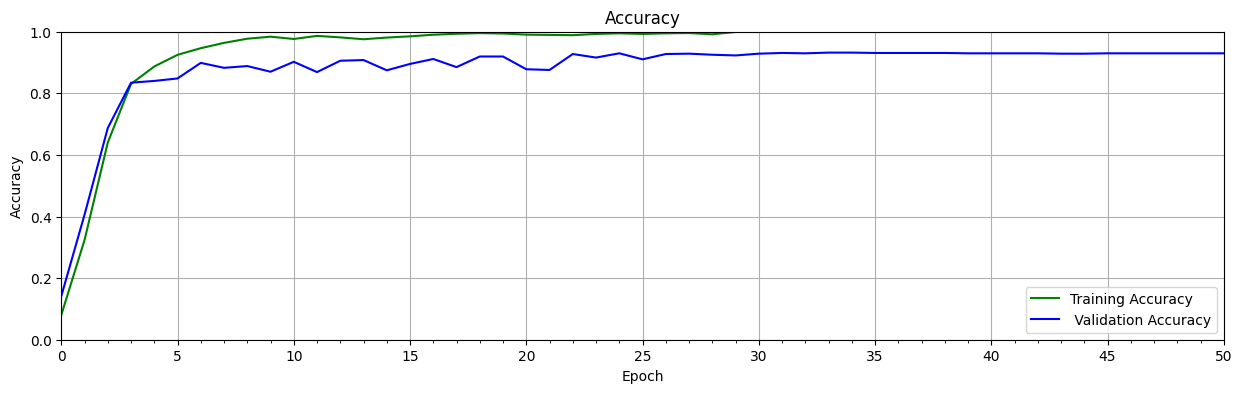

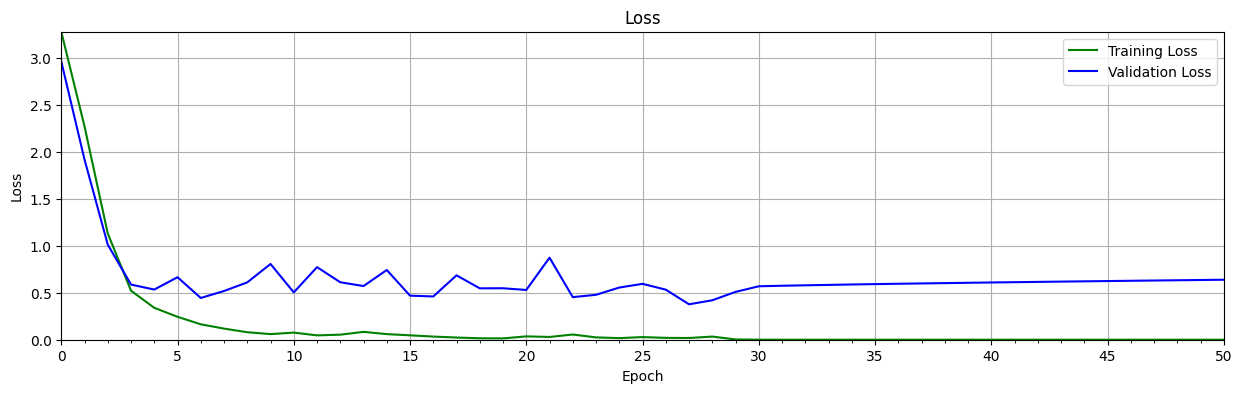

In [ ]:
train_loss = trainig_results.history['loss']
train_acc  = trainig_results.history['accuracy']
valid_loss = trainig_results.history['val_loss']
valid_acc  = trainig_results.history['val_accuracy']

max_loss = max(max(train_loss), max(valid_loss))
plot_results([train_acc, valid_acc], ylabel = 'Accuracy',
                ylim=[0.0, 1.0],
                metric_name = ["Training Accuracy"," Validation Accuracy"],
                color=["g","b"])

plot_results([train_loss, valid_loss], ylabel = 'Loss',
                ylim=[0.0, max_loss],
                metric_name = ["Training Loss", "Validation Loss"],
                color=["g","b"])



In [ ]:
print(f"Model evaluation accuracy: {vgg16_model.evaluate(valid_dataset)[1]*100.:.3f}")

28/28 [==============================] - 4s 117ms/step - loss: 0.6392 - accuracy: 0.9299
Model evaluation accuracy: 92.989
